In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"radioactive11","key":"79143e8a25770d14ec81d3d1b84a84a5"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:52<00:00, 58.2MB/s]
100% 2.29G/2.29G [00:52<00:00, 46.5MB/s]


In [ ]:
!unzip chest-xray-pneumonia.zip
!rm chest-xray-pneumonia.zip

In [ ]:
!pip install livelossplot

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import shutil
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
from livelossplot import PlotLossesKerasTF
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.3.0


In [ ]:
train_dir = "chest_xray/train/PNEUMONIA/"

train_pnemonia = os.listdir("chest_xray/train/PNEUMONIA/")
train_normal = os.listdir("chest_xray/train/NORMAL/")

In [ ]:
print("There are " + str(len(train_normal)) + " samples for normal scans.")
print("There are " + str(len(train_pnemonia)) + " samples for effected scans.")

There are 1341 samples for normal scans.
There are 3875 samples for effected scans.


In [ ]:
viral = []
bacterial = []

for img in train_pnemonia:
    if("bacteria" in img):
        bacterial.append(img)
    else:
        viral.append(img)
print("There are " + str(len(viral)) + " train samples for viral")
print("There are " + str(len(bacterial)) + " train samples for bacterial")

There are 1345 train samples for viral
There are 2530 train samples for bacterial


In [ ]:
if (not os.path.isdir(os.path.join(train_dir, "viral"))):
    os.mkdir(os.path.join(train_dir, "viral"))
    
if (not os.path.isdir(os.path.join(train_dir, "bacterial"))):
    os.mkdir(os.path.join(train_dir, "bacterial"))
    
for file in viral:
    shutil.move(os.path.join(train_dir, file), os.path.join(train_dir, "viral"))
    
for file in bacterial:
    shutil.move(os.path.join(train_dir, file), os.path.join(train_dir, "bacterial"))
  

In [ ]:
test_dir = "chest_xray/test/PNEUMONIA/"

test_pneumonia = os.listdir("chest_xray/test/PNEUMONIA/")
test_normal = os.listdir("chest_xray/test/NORMAL/")

In [ ]:
viral = []
bacterial = []

for img in test_pneumonia:
    if("bacteria" in img):
        bacterial.append(img)
    else:
        viral.append(img)
print("There are " + str(len(viral)) + " test samples for viral")
print("There are " + str(len(bacterial)) + " test samples for bacterial")

There are 148 test samples for viral
There are 242 test samples for bacterial


In [ ]:
if (not os.path.isdir(os.path.join(test_dir, "viral"))):
    os.mkdir(os.path.join(test_dir, "viral"))
    
if (not os.path.isdir(os.path.join(test_dir, "bacterial"))):
    os.mkdir(os.path.join(test_dir, "bacterial"))
    
for file in viral:
    shutil.move(os.path.join(test_dir, file), os.path.join(test_dir, "viral"))
    
for file in bacterial:
    shutil.move(os.path.join(test_dir, file), os.path.join(test_dir, "bacterial"))

In [ ]:
!pwd

/content


In [ ]:
%rm -r chest_xray/chest_xray/

In [ ]:
os.rename("chest_xray/test/NORMAL", "chest_xray/test/normal")
os.rename("chest_xray/train/NORMAL", "chest_xray/train/normal")

In [ ]:
shutil.move("chest_xray/test/normal", "chest_xray/test/PNEUMONIA")

'chest_xray/test/PNEUMONIA/normal'

In [ ]:
shutil.move("chest_xray/train/normal", "chest_xray/train/PNEUMONIA")

'chest_xray/train/PNEUMONIA/normal'

In [ ]:
os.rename("chest_xray/test/PNEUMONIA", "chest_xray/test/images")
os.rename("chest_xray/train/PNEUMONIA", "chest_xray/train/images")

In [ ]:
try:
  os.rmdir("chest_xray/train/images/.ipynb_checkpoints")
except:
  print("file doesnt exist")

file doesnt exist


In [ ]:
try:
  os.rmdir("chest_xray/test/images/.ipynb_checkpoints")
except:
  print("file doesnt exist")

file doesnt exist


In [ ]:
print("Training set detaiils: ")
for i in os.listdir("chest_xray/train/images/"):
    print(str(len(os.listdir("chest_xray/train/images/" + i))) + " " + i + " images")

Training set detaiils: 
1345 viral images
2530 bacterial images
1341 normal images


In [ ]:
print("Test set detaiils: ")
for i in os.listdir("chest_xray/test/images/"):
    print(str(len(os.listdir("chest_xray/test/images/" + i))) + " " + i + " images")

Test set detaiils: 
148 viral images
242 bacterial images
234 normal images


In [ ]:
image_size = 277
batch_size = 64

datagen_train = ImageDataGenerator(rotation_range=5,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    rescale=1./255,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')


train_generator = datagen_train.flow_from_directory("chest_xray/train/images",
                                                   target_size = (image_size, image_size),
                                                   color_mode = "rgb",
                                                   batch_size = batch_size,
                                                   class_mode = "categorical",
                                                   shuffle = True)


Found 5216 images belonging to 3 classes.


In [ ]:
image_size = 277
batch_size = 64

datagen_test = ImageDataGenerator(rotation_range=5,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    rescale=1./255,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')


test_generator = datagen_test.flow_from_directory("chest_xray/test/images",
                                                   target_size = (image_size, image_size),
                                                   color_mode = "rgb",
                                                   batch_size = batch_size,
                                                   class_mode = "categorical",
                                                   shuffle = False)

Found 624 images belonging to 3 classes.


In [ ]:
model = Sequential()

# 1 - Convolution layer
model.add(Conv2D(64, (3,3), padding = "same", input_shape = (277, 277, 3)))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 5th Convolution layer
model.add(Conv2D(256,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(3, activation='softmax'))

opt = Adam(lr=0.005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 277, 277, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 277, 277, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 277, 277, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 138, 138, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 138, 138, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 138, 138, 128)     204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 138, 138, 128)     5

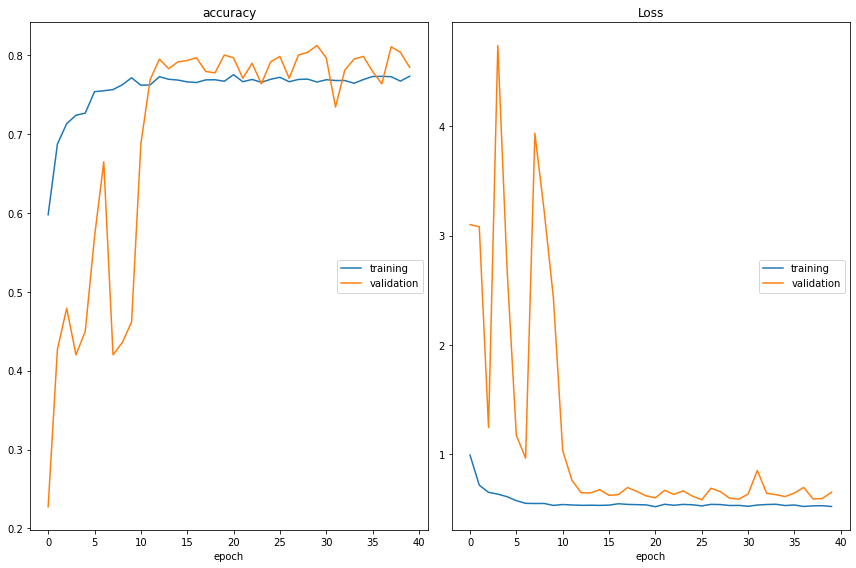

accuracy
	training         	 (min:    0.598, max:    0.775, cur:    0.773)
	validation       	 (min:    0.227, max:    0.812, cur:    0.785)
Loss
	training         	 (min:    0.519, max:    0.992, cur:    0.522)
	validation       	 (min:    0.583, max:    4.740, cur:    0.652)

Epoch 00040: saving model to model_weights.h5
81/81 [==============================] - 193s 2s/step - loss: 0.5216 - accuracy: 0.7735 - val_loss: 0.6519 - val_accuracy: 0.7847


In [ ]:
epochs = 40
steps_per_epoch = train_generator.n//train_generator.batch_size
test_steps = test_generator.n//test_generator.batch_size

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)
callbacks = [PlotLossesKerasTF(), checkpoint, reduce_lr]

history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = test_generator,
    validation_steps = test_steps,
    callbacks=callbacks
)

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)